#### Red neuronal que reproduce funciones.

Las funciones serán trabajadas en el intervalo [-1,1] y son las siguientes:

- (a) $3sin$($\pi$ $x$)
- (b) $1 + 2x + 4x^3$

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from matplotlib import pyplot as plt
import numpy as np
import math

In [21]:
loss_tracker = keras.metrics.Mean(name="loss")

# Capa personalizada
class SinTransform(tf.keras.layers.Layer): 
    def __init__(self, num_outputs):
        super(SinTransform, self).__init__()
        self.num_outputs = num_outputs #número de modos
        self.freq = tf.range(1., self.num_outputs + 1) #vector de frecuencias

        #vector del mismo tamaño del de frecuencias, entrenable, son los coefiicientes (a_0,a_1,..)
        self.kernel = self.add_weight(
            name="kernel",
            shape=(self.num_outputs,),
            trainable=True
        )

    def call(self, inputs): 
        inputs = tf.convert_to_tensor(inputs)
        if (inputs.shape == ()): #si es un escalar se vuuelve un vector de 1D
            inputs = (inputs,)
        elif (len(inputs.shape) == 1): # si es un vector de 1D, lo convierte en una matriz columna 
            inputs = tf.expand_dims(inputs, axis=1) 

        batch = tf.shape(inputs)[0] #guarda el tamaño del mini batch
        #vector columna del tamaño del minibatch por las frecuencias (1,2,3...):
        self.freq_b = tf.ones([batch,1])*self.freq
        args = self.freq_b*inputs #argumentos que van dentro de la función seno (1x,2x,3x,..)
        modes = tf.math.sin(args) #modos 
        return tf.tensordot(modes,self.kernel,1) #producto punto de los modos con los coeficientes
        # a_0 + a_1sin(x) + a_2sin(2x) + ...

In [23]:
# Modelo con train_step para la función seno
class FunsolSin(keras.Model): #clase 
    @property
    def metrics(self):
        return [loss_tracker] #cambia loss_tracker 

    def train_step(self, data):
        batch_size = 10 #resolución de la ec diferencial
        #vector con valores aleatorios entre -1 y 1:
        x = tf.random.uniform((batch_size,), minval=-1, maxval=1) 
        eq = 3*tf.math.sin(np.pi * x)   #función a reproducir 

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True) 
            loss = keras.losses.MeanSquaredError()
            loss = loss(eq,y_pred) #error comparando los valores de la función y los de la predicción

        grads = tape.gradient(loss, self.trainable_weights) #gradientes de la función de costo 
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        loss_tracker.update_state(loss) #actualiza métricas 

        return {"loss": loss_tracker.result()}

In [27]:
trans = SinTransform(6) #probamos con 6 modos
x = tf.random.uniform((6,), minval=-1, maxval=1)
print(x)
res = trans(x)
print(res)

tf.Tensor([-0.15126228  0.8426006  -0.3061335   0.35582948 -0.27191663  0.0974896 ], shape=(6,), dtype=float32)
tf.Tensor([ 0.24623543  1.2746973   0.1973992  -0.0968082   0.24290904 -0.17978998], shape=(6,), dtype=float32)


In [31]:
inputs = keras.Input(shape=(1,))
x = SinTransform(10)(inputs) #10 parametros entrenables (coeficientes)
model_sin = FunsolSin(inputs=inputs, outputs=x)

model_sin.compile(optimizer=tf.keras.optimizers.Adam(0.01)) #entrenamos con Adam, eta=0.01

# Entrenamiento en iintervalo [-1,1], 100 puntos, 200 épocas
history = model_sin.fit(tf.linspace(-1.,1.,100), epochs=200, verbose=1) 

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.6753 
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.4902
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7276
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8075
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2340
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4277
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9752
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8190
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7736
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4958
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5120
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3733
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2796
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2035
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1672 
Epoch 16/200
4/4 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


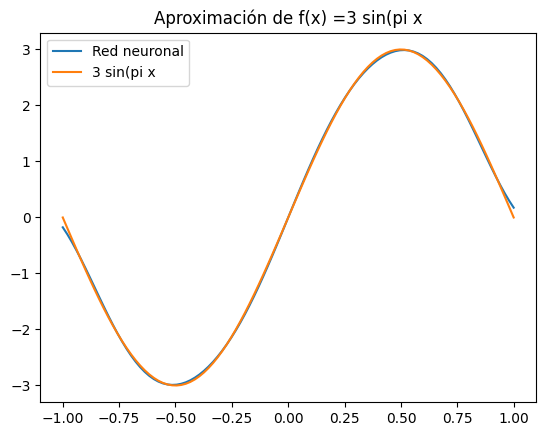

In [41]:
x_test = tf.linspace(-1.,1.,100)
y_pred = model_sin.predict(x_test)

plt.plot(x_test, y_pred, label="Red neuronal")
plt.plot(x_test, 3*np.sin(np.pi*x_test), label="3 sin(pi x")
plt.legend(); plt.title("Aproximación de f(x) =3 sin(pi x")
plt.show()


#### b) $1 + 2x + 4x^3$

In [44]:
# Modelo con train_step para el polinomio
class FunsolPoly(keras.Model):
    @property
    def metrics(self):
        return [loss_tracker]

    def train_step(self, data):
        batch_size = 10
        x = tf.random.uniform((batch_size,), minval=-1, maxval=1)
        eq = 1 + 2*x + 4*tf.pow(x, 3)   # función polinómica

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = keras.losses.MeanSquaredError()
            loss = loss(eq,y_pred)

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        loss_tracker.update_state(loss)

        return {"loss": loss_tracker.result()}


In [52]:
# Definición del modelo
inputs = keras.Input(shape=(1,))
x = SinTransform(10)(inputs)
model_poly = FunsolPoly(inputs=inputs, outputs=x) #ahora usamos Funsolpoly

model_poly.compile(optimizer=tf.keras.optimizers.Adam(0.01)) #igual con Adam
# Entrenamiento
history = model_poly.fit(tf.linspace(-1.,1.,200), epochs=200, verbose=1) 

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.7187  
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9152 
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0776 
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.9360 
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7440 
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2755 
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3063 
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2849 
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.6906  
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2268  
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6598 
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7758 
Epoch 13/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0065 
Epoch 14/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0238 
Epoch 15/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2759 
Epoch 16/200
7

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


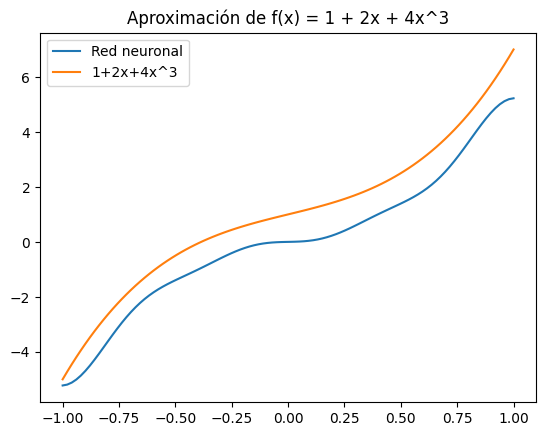

In [54]:
# Predicción y gráfica
x_test = tf.linspace(-1.,1.,100)
y_pred = model_poly.predict(x_test)

plt.plot(x_test, y_pred, label="Red neuronal")
plt.plot(x_test, 1 + 2*x_test + 4*tf.pow(x_test,3), label="1+2x+4x^3")
plt.legend(); plt.title("Aproximación de f(x) = 1 + 2x + 4x^3")
plt.show()


No se ajusta tan bien, debido a que la clase SinTransform se define como una base senoidal, no es tan natural para funciones polinómicas.

Podemos definir otra clase, pero que trabaje con polinomios como modos.

In [58]:
class PolyTransform(tf.keras.layers.Layer):
    def __init__(self, degree):
        super(PolyTransform, self).__init__()
        self.degree = degree #grados del polinomio

        # Coeficientes entrenables a0, a1, ..., an
        self.kernel = self.add_weight(
            name="kernel",
            shape=(self.degree + 1,),
            trainable=True
        )

    def call(self, inputs):
        inputs = tf.convert_to_tensor(inputs)
        if (inputs.shape == ()):
            inputs = (inputs,)
        elif (len(inputs.shape) == 1):
            inputs = tf.expand_dims(inputs, axis=1)

        batch = tf.shape(inputs)[0]
        powers = [tf.pow(inputs, i) for i in range(self.degree + 1)] #lista de potencias de x
        features = tf.concat(powers, axis=1)  #juntar potencias en una matriz, base de polinomios

        # Producto punto con los coeficientes
        return tf.tensordot(features, self.kernel, 1)
        # a_0 + a_1x + a_2x^2 +...

In [75]:
# Definición del modelo
inputs = keras.Input(shape=(1,))
x = PolyTransform(10)(inputs)
model_poly2 = FunsolPoly(inputs=inputs, outputs=x) #ahora usamos Funsolpoly

model_poly2.compile(optimizer=tf.keras.optimizers.Adam(0.01)) #igual con Adam
# Entrenamiento con el intervalo [-1,1], 200 puntos y 200 épocas 
history = model_poly2.fit(tf.linspace(-1.,1.,200), epochs=200, verbose=1) 

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.8930 
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.0497  
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4908  
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6758 
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2414
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2511
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.0396
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9812 
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7087 
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5380 
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.7859
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.3154
Epoch 13/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1780 
Epoch 14/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7765 
Epoch 15/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6976 
Epoch 16/200
7/

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


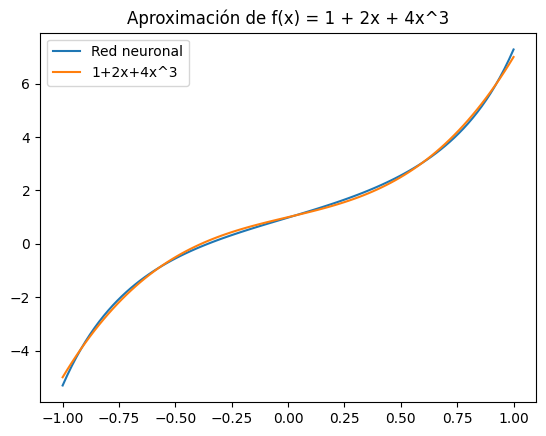

In [77]:
# Predicción y gráfica
x_test = tf.linspace(-1.,1.,100)
y_pred = model_poly2.predict(x_test)

plt.plot(x_test, y_pred, label="Red neuronal")
plt.plot(x_test, 1 + 2*x_test + 4*tf.pow(x_test,3), label="1+2x+4x^3")
plt.legend(); plt.title("Aproximación de f(x) = 1 + 2x + 4x^3")
plt.show()

Evidentemente, ajusto mucho mejor para reproducir la función.

### Diseñar una capa entrenable que represente un polinomio de grado 3. Los parámetros entrenables son los coeficientes a_0, a_1, a_2,a_3. Posteriormente entrenarla para ajustar la función cos(2x) en el intervalo [-1,1].

Podemos usar la clase utilizada en el polinomio (PolyTransform), ya que en escencia es lo mismo, pero definiendo específicamente el número de grados y de constantes.

In [81]:
class PolyTransform2(tf.keras.layers.Layer):
    def __init__(self, degree):
        super(PolyTransform2, self).__init__()
        self.degree = 3 #es de grado 3

        # Coeficientes entrenables a0, a1, ..., an
        self.kernel = self.add_weight(
            name="kernel",
            shape=(self.degree + 1,),
            trainable=True
        )

    def call(self, inputs):
        inputs = tf.convert_to_tensor(inputs)
        if (inputs.shape == ()):
            inputs = (inputs,)
        elif (len(inputs.shape) == 1):
            inputs = tf.expand_dims(inputs, axis=1)

        #batch = tf.shape(inputs)[0]
        #powers = [tf.pow(inputs, i) for i in range(self.degree + 1)] 
        #definimos directamente los vectores para crear la función:
        x0= tf.ones_like(inputs) #(x_i)^0 = 1
        x1= inputs #(x_i)^1 = x_i
        x2= tf.pow(inputs,2) # (x_i)^2
        x3= tf.pow(inputs,3) #(x_i)^3

        #features = tf.concat(powers, axis=1) 
        features = tf.concat([x0,x1,x2,x3], axis=1)
        # Producto punto con los coeficientes
        return tf.tensordot(features, self.kernel, 1)
        # a_0 + a_1x + a_2x^2 + a_3x^3

In [87]:
class FunsolCos(keras.Model):
    @property
    def metrics(self):
        return [loss_tracker]

    def train_step(self, data):
        batch_size = 10
        x = tf.random.uniform((batch_size,), minval=-1, maxval=1)
        eq = tf.cos(2*x)  # función a reproducir 

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = keras.losses.MeanSquaredError()
            loss = loss(eq,y_pred)

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        loss_tracker.update_state(loss)

        return {"loss": loss_tracker.result()}


In [89]:
inputs = keras.Input(shape=(1,))
x = PolyTransform2(10)(inputs)
model_cos = FunsolCos(inputs=inputs, outputs=x) #ahora usamos Funsolpoly

model_cos.compile(optimizer=tf.keras.optimizers.Adam(0.01)) #igual con Adam
# Entrenamiento con el intervalo [-1,1], 200 puntos y 200 épocas 
history = model_cos.fit(tf.linspace(-1.,1.,200), epochs=200, verbose=1) 

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5561
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5673 
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3778
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3657
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3045 
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2941
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2806
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2713
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2283
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1768
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1726
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1458
Epoch 13/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1540 
Epoch 14/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1425
Epoch 15/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0956 
Epoch 16/200
7/

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


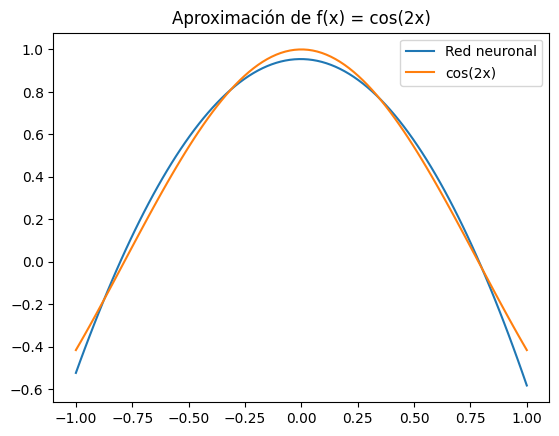

In [95]:
# Predicción y gráfica
x_test = tf.linspace(-1.,1.,100)
y_pred = model_cos.predict(x_test)

plt.plot(x_test, y_pred, label="Red neuronal")
plt.plot(x_test, np.cos(2*x_test), label="cos(2x)")
plt.legend(); plt.title("Aproximación de f(x) = cos(2x)")
plt.show()

Aproxima bastante bien con tan solo un polinomio de grado 3.